# Logistic Regression on basic numerical data

# Relevant Imports

In [1]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



# Adding Sentiment Score as a feature

## Load annotated sentiment file

In [3]:
# Load the dataset
file_path = '../../../dataset_final/Daily_Financial_News/MRK/MRK_text_annotated.csv'
file_path_num = '../../../dataset_final/Daily_Financial_News/MRK/MRK_numerical_LR.csv'

data = pd.read_csv(file_path_num)
data_sent = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data_sent.head())

   Unnamed: 0                                              title stock  \
0      838963  Shares of several healthcare companies are tra...   MRK   
1      838964  Johnson & Johnson To Start Coronavirus Vaccine...   MRK   
2      838965  The Daily Biotech Pulse: Keytruda Setback For ...   MRK   
3      838966  Merck Announces That The Phase 3 KEYNOTE-361 T...   MRK   
4      838967  The Week Ahead In Biotech: Viela FDA Decision,...   MRK   

         Date  sentiment_score  
0  2020-06-11            -0.31  
1  2020-06-11             0.01  
2  2020-06-10            -0.38  
3  2020-06-09             0.00  
4  2020-06-07             0.01  


In [4]:
# Check if 'Unnamed: 0' exists in the columns and drop it
if 'Unnamed: 0' in data_sent.columns:
    data_sent = data_sent.drop(columns=['Unnamed: 0'])
data_sent.rename(columns={'Time': 'Date'}, inplace=True)
data_sent.head()

,title,stock,Date,sentiment_score
0,Shares of several healthcare companies are tra...,MRK,2020-06-11,-0.31
1,Johnson & Johnson To Start Coronavirus Vaccine...,MRK,2020-06-11,0.01
2,The Daily Biotech Pulse: Keytruda Setback For ...,MRK,2020-06-10,-0.38
3,Merck Announces That The Phase 3 KEYNOTE-361 T...,MRK,2020-06-09,0.00
4,"The Week Ahead In Biotech: Viela FDA Decision,...",MRK,2020-06-07,0.01


# Merging the two dataframes

In [5]:
# Ensure the Date columns are in datetime format in both DataFrames
data_sent['Date'] = pd.to_datetime(data_sent['Date'])
data['Date'] = pd.to_datetime(data['Date'])


# Calculate the aggregate sentiment score for each date in sentiment_data
aggregate_sentiment = data_sent.groupby('Date', as_index=False)['sentiment_score'].sum()
aggregate_sentiment.rename(columns={'sentiment_score': 'aggregate_sentiment_score'}, inplace=True)

# Merge the stock data (data) with the aggregated sentiment data
merged_data = pd.merge(data, aggregate_sentiment, on='Date', how='inner')

# Select the required columns
final_data = merged_data[['Date', 'Open', 'Close', 'High', 'Volume', 'aggregate_sentiment_score']]

# Inspect the final DataFrame
final_data.head()


,Date,Open,Close,High,Volume,aggregate_sentiment_score
0,2009-08-07,28.34,28.72,29.10,13656278.0,0.01
1,2009-08-10,28.90,29.19,29.58,19050963.0,0.02
2,2009-08-17,29.19,29.46,29.91,19584290.0,0.00
3,2009-09-18,30.70,30.41,30.87,21274086.0,0.05
4,2009-11-04,29.89,31.14,31.34,37948290.0,-0.13


In [6]:
# Calculate next-day return
final_data['Movement'] = ((final_data['Open'].shift(-1) - final_data['Close']) / data['Close'])

# Shift Movement to align with current day
final_data['Movement'] = final_data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
final_data = final_data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
final_data['Movement'] = (final_data['Movement'] > 0).astype(int)

# Calculate daily returns (in percentage)
final_data['Daily_Return'] = final_data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
final_data['Volatility'] = final_data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
final_data = final_data.dropna(subset=['Volatility'])

# Define a rolling window size for sentiment volatility
sentiment_window_size = 5  # You can adjust the window size as needed

# Calculate rolling standard deviation of the aggregate sentiment score
final_data['sentiment_volatility'] = final_data['aggregate_sentiment_score'].rolling(window=sentiment_window_size).std()

# Create lagged sentiment volatility to avoid data leakage
final_data['sentiment_volatility_lag1'] = final_data['sentiment_volatility'].shift(1)

# Create lagged sentiment volatility to avoid data leakage
final_data['aggregate_sentiment_score_lag1'] = final_data['aggregate_sentiment_score'].shift(1)

# Drop rows with NaN values introduced by rolling and shifting
final_data = final_data.dropna(subset=['sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1'])

# Create lagged features to avoid data leakage
final_data['Close_lag1'] = final_data['Close'].shift(1)
final_data['High_lag1'] = final_data['High'].shift(1)
final_data['Volume_lag1'] = final_data['Volume'].shift(1)
final_data['Daily_Return_lag1'] = final_data['Daily_Return'].shift(1)
final_data['Volatility_lag1'] = final_data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
final_data = final_data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1', 'sentiment_volatility_lag1'])


final_data.head(10)

/var/folders/pd/35sqmnx90k31hxsfkmzt115m000cd0/T/ipykernel_5891/3626410606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Movement'] = ((final_data['Open'].shift(-1) - final_data['Close']) / data['Close'])
/var/folders/pd/35sqmnx90k31hxsfkmzt115m000cd0/T/ipykernel_5891/3626410606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Movement'] = final_data['Movement'].shift(1)


,Date,Open,Close,High,Volume,aggregate_sentiment_score,Movement,Daily_Return,Volatility,sentiment_volatility,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
12,2009-12-10,35.69,35.82,36.18,15336642.0,-0.16,1,3.287197,3.376662,0.285797,0.260538,0.00,34.68,35.29,16286234.0,-1.224722,3.682028
13,2009-12-14,35.56,36.04,36.06,12981262.0,0.01,0,0.614182,3.495141,0.285096,0.285797,-0.16,35.82,36.18,15336642.0,3.287197,3.376662
14,2009-12-16,36.27,36.02,36.35,17476238.0,0.19,1,-0.055494,1.660140,0.123976,0.285096,0.01,36.04,36.06,12981262.0,0.614182,3.495141
15,2009-12-18,35.64,35.68,36.05,26643618.0,0.21,0,-0.943920,1.803765,0.152807,0.123976,0.19,36.02,36.35,17476238.0,-0.055494,1.660140
16,2009-12-21,35.76,35.96,36.66,15497090.0,0.62,1,0.784753,1.579114,0.291084,0.152807,0.21,35.68,36.05,26643618.0,-0.943920,1.803765
17,2009-12-22,36.05,36.02,36.24,14771350.0,0.00,1,0.166852,0.680222,0.251257,0.291084,0.62,35.96,36.66,15497090.0,0.784753,1.579114
18,2009-12-23,36.12,35.54,36.12,13358542.0,-0.12,1,-1.332593,0.856219,0.281514,0.251257,0.00,36.02,36.24,14771350.0,0.166852,0.680222
19,2009-12-24,35.43,35.29,35.43,6586890.0,-0.56,0,-0.703433,0.863489,0.433590,0.281514,-0.12,35.54,36.12,13358542.0,-1.332593,0.856219
20,2009-12-28,35.29,35.58,35.66,10443634.0,0.02,0,0.821763,0.945489,0.422043,0.433590,-0.56,35.29,35.43,6586890.0,-0.703433,0.863489
21,2010-01-04,35.13,35.31,35.54,14563532.0,0.00,0,-0.758853,0.851043,0.245601,0.422043,0.02,35.58,35.66,10443634.0,0.821763,0.945489


# Saving the merged dataset

In [7]:
final_data.to_csv('../../../dataset_final/Daily_Financial_News/MRK/merged_MRK.csv')

# Define features and target value

In [8]:
final_data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'aggregate_sentiment_score',
       'Movement', 'Daily_Return', 'Volatility', 'sentiment_volatility',
       'sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1',
       'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1',
       'Volatility_lag1'],
      dtype='object')

In [9]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['aggregate_sentiment_score', 'sentiment_volatility', 'sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = final_data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


aggregate_sentiment_score         0.085542
sentiment_volatility              0.026911
sentiment_volatility_lag1         0.023396
aggregate_sentiment_score_lag1    0.005250
Name: Movement, dtype: float64


In [10]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1', 'aggregate_sentiment_score_lag1', 'sentiment_volatility_lag1']
X = final_data[features]
y = final_data['Movement']


# Splitting and scaling the data

In [11]:
# Ensure the 'Date' column is in datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'])  # Ensure correct datetime format
final_data.set_index('Date', inplace=True)
print(final_data.index)


DatetimeIndex(['2009-12-10', '2009-12-14', '2009-12-16', '2009-12-18',
               '2009-12-21', '2009-12-22', '2009-12-23', '2009-12-24',
               '2009-12-28', '2010-01-04',
               ...
               '2020-05-26', '2020-05-28', '2020-05-29', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=1436, freq=None)


In [12]:
X.index = final_data.index
print(X.index)

DatetimeIndex(['2009-12-10', '2009-12-14', '2009-12-16', '2009-12-18',
               '2009-12-21', '2009-12-22', '2009-12-23', '2009-12-24',
               '2009-12-28', '2010-01-04',
               ...
               '2020-05-26', '2020-05-28', '2020-05-29', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=1436, freq=None)


In [13]:
# Initialize lists to store train and test years
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]
    
    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)
    
    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2009-12-10 to 2011-10-26
Test Dates: 2011-10-28 to 2013-11-18
--------------------------------------------------
Fold 2:
Train Dates: 2009-12-10 to 2013-11-18
Test Dates: 2013-11-22 to 2015-10-07
--------------------------------------------------
Fold 3:
Train Dates: 2009-12-10 to 2015-10-07
Test Dates: 2015-10-08 to 2017-07-10
--------------------------------------------------
Fold 4:
Train Dates: 2009-12-10 to 2017-07-10
Test Dates: 2017-07-12 to 2019-01-28
--------------------------------------------------
Fold 5:
Train Dates: 2009-12-10 to 2019-01-28
Test Dates: 2019-01-29 to 2020-06-10
--------------------------------------------------


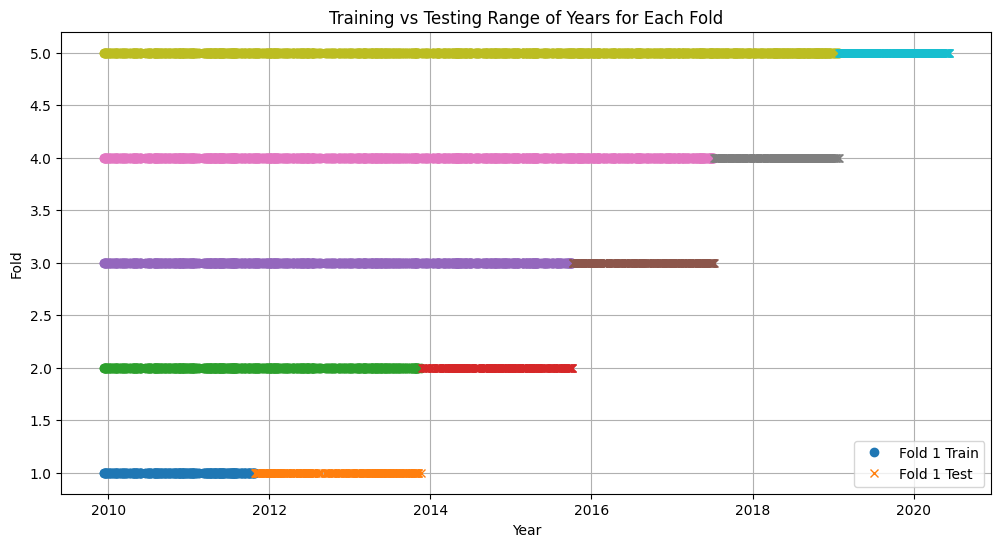

In [14]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Model training and evaluation


Fold 1 Confusion Matrix:
[[107  10]
 [ 17 105]]


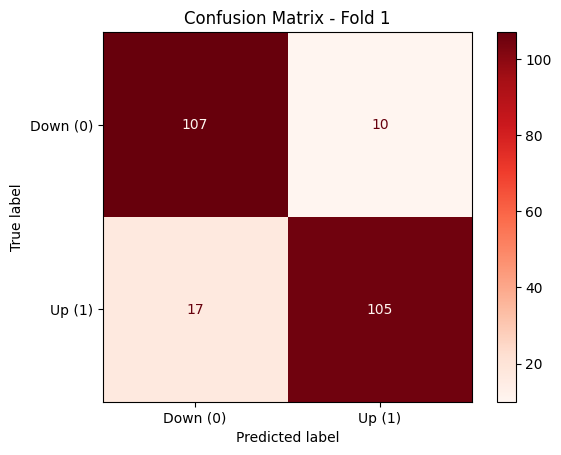

Fold 1 Accuracy: 0.89
--------------------------------------------------

Fold 2 Confusion Matrix:
[[107   3]
 [ 30  99]]


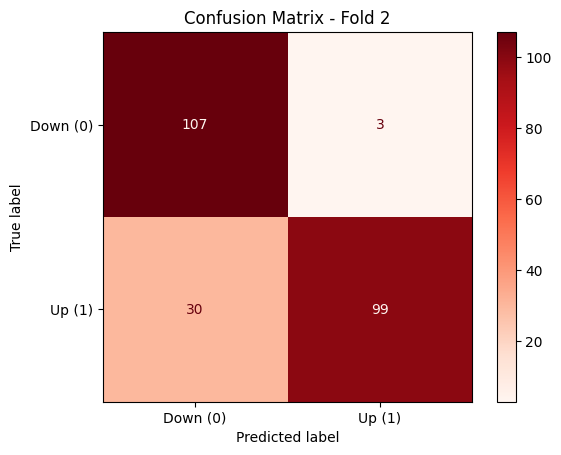

Fold 2 Accuracy: 0.86
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 93  29]
 [ 14 103]]


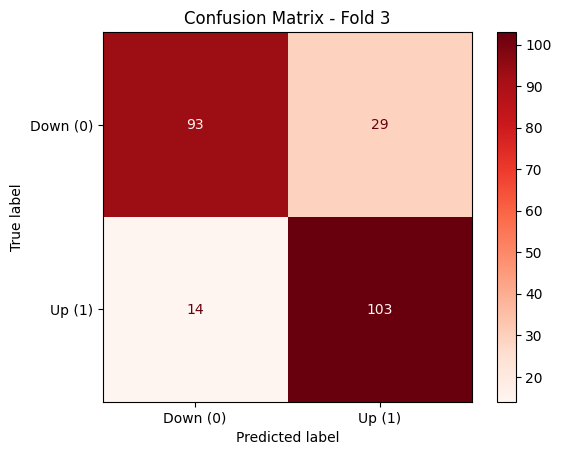

Fold 3 Accuracy: 0.82
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 74  27]
 [ 14 124]]


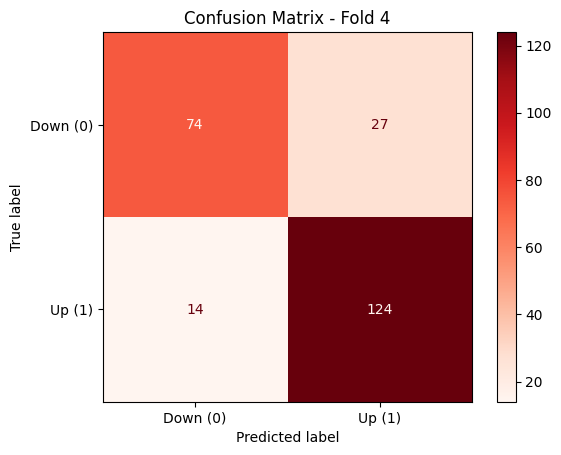

Fold 4 Accuracy: 0.83
--------------------------------------------------

Fold 5 Confusion Matrix:
[[ 77  30]
 [  7 125]]


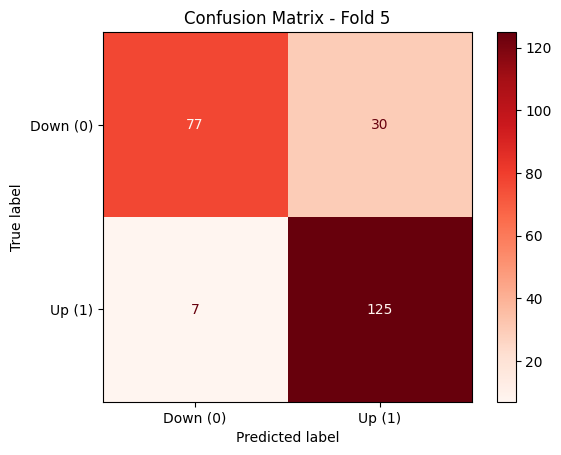

Fold 5 Accuracy: 0.85
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.85
Precision: 0.86
Recall: 0.87
F1-Score: 0.86
ROC-AUC: 0.94

Cross-Validation Accuracy: 0.8485 ± 0.0240


In [15]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Reds")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()
    
    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nCross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


# Evaluation on balanced data

Fold 1 - Balanced Class Distribution:
Movement
0    117
1    117
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[109   8]
 [ 21 101]]


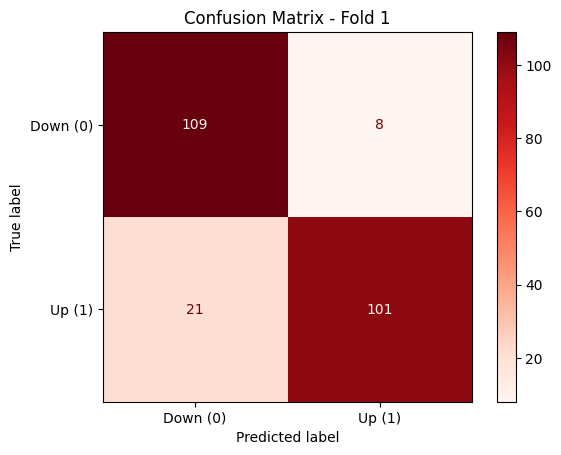

Fold 1 Accuracy: 0.88
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    234
1    234
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[108   2]
 [ 33  96]]


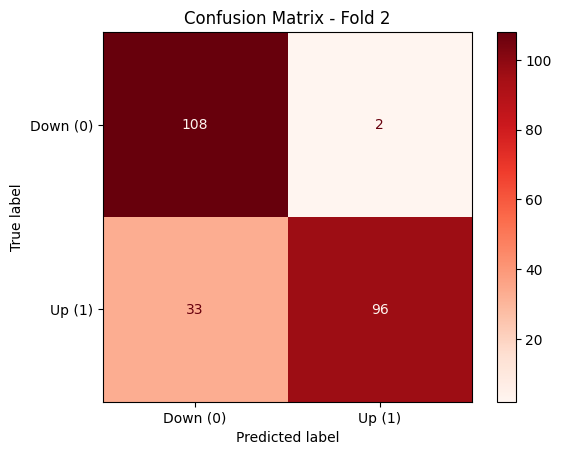

Fold 2 Accuracy: 0.85
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    344
1    344
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[103  19]
 [ 22  95]]


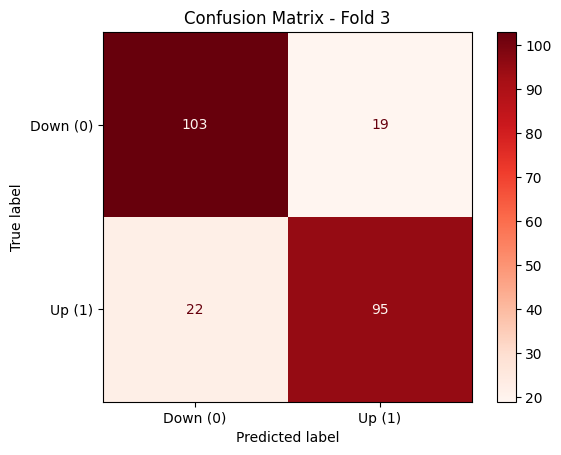

Fold 3 Accuracy: 0.83
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    466
1    466
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 82  19]
 [ 20 118]]


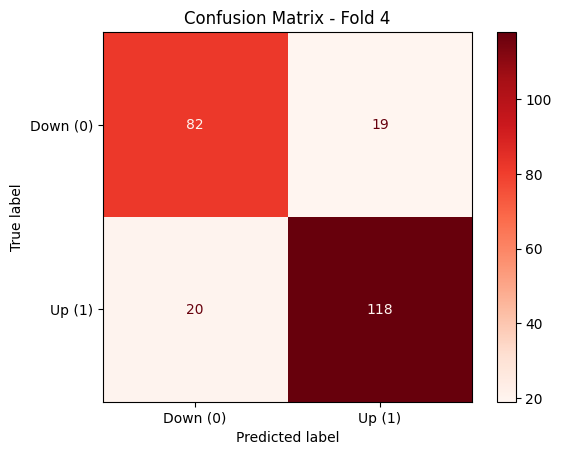

Fold 4 Accuracy: 0.84
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    567
1    567
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[ 95  12]
 [ 12 120]]


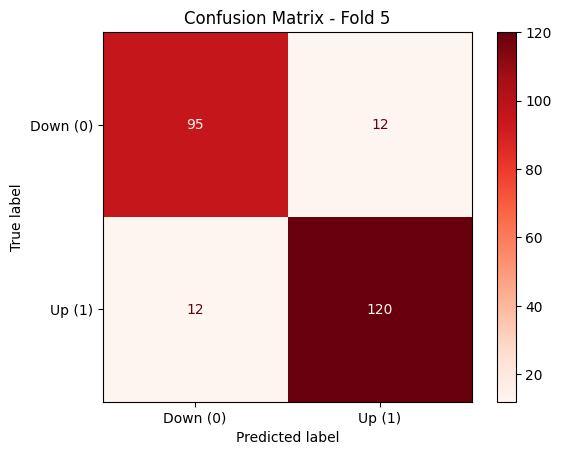

Fold 5 Accuracy: 0.90
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.86
Precision: 0.90
Recall: 0.83
F1-Score: 0.86
ROC-AUC: 0.94

Cross-Validation Accuracy: 0.8594 ± 0.0264


In [16]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)
    
    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Reds")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nCross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


# Hyperparameter Tuning

## Grid search

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

tss1 = TimeSeriesSplit(n_splits=3)
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],            # Test both L1 (sparse) and L2 (ridge) regularization
    'C': [0.001, 0.01, 0.1, 1],            # A modest range of regularization strengths
    'solver': ['liblinear']             # 'liblinear' is usually efficient for smaller datasets
}


# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Loop over folds with proper unpacking
for fold_number, (train_idx, test_idx) in enumerate(tss1.split(X)):
    # Split data into training/test sets using indices
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Balance training data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Hyperparameter tuning with GridSearchCV
    model = LogisticRegression(random_state=42, max_iter=2000)
    grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=TimeSeriesSplit(n_splits=3),  # or more splits
    n_jobs=-1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print results
    print(f"\nFold {fold_number + 1} Best Parameters: {grid_search.best_params_}")
    print(f"Fold {fold_number + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 1 Accuracy: 0.99
--------------------------------------------------

Fold 2 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 2 Accuracy: 0.97
--------------------------------------------------

Fold 3 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 3 Accuracy: 0.97
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.98
Precision: 0.97
Recall: 0.99
F1-Score: 0.98
ROC-AUC: 1.00
